In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import os
#from google.colab import drive
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, ImageOps
import pandas as pd

In [10]:
#drive.mount('/content/drive', force_remount=True) 
datapath = "horus2.0/fer2013.csv"  
path = "horus2.0/"
df = pd.read_csv(datapath)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
#drive.mount('/content/drive', force_remount=True) 
datapath = "horus2.0/fer2013new.csv"  
path = "horus2.0/"
dfplus = pd.read_csv(datapath)
dfplus.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [12]:
#drive.mount('/content/drive', force_remount=True) 
datapath = "horus2.0/label_expw.csv"  
path = "horus2.0/"
dfexpw = pd.read_csv(datapath)
dfexpw.head()

,awe_grandmother_214_0.png,"(0, 0, 48, 48)",0,0.1,0.2,0.3,0.4,0.5,10,0.6,0.7,0.8
0,mad_woman_303_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
1,fierce_european_896_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
2,annoyed_father_453_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
3,mad_infant_734_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
4,angry_son_1_1.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0


In [ ]:
#fer2013
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
print(y_train[0])

In [13]:
#ferplus
X_train = []
y_train = []
X_test = []
y_test = []
x_valid = []
y_valid = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        #y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        #y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        x_valid.append(np.array(k))


for index, row in dfplus.iterrows():  
    if row["NF"] == 10:
      label = -2
    else: 
      max_row = np.argmax([row["neutral"],row["happiness"], row["surprise"], row["sadness"],row["anger"],row["disgust"],row["fear"]])
      label = -1
      if max_row == 0:
        label = 6
      if max_row == 1:
        label = 3
      if max_row == 2:
        label = 5
      if max_row == 3:
        label = 4
      if max_row == 4:
        label = 0
      if max_row == 5:
        label = 1
      if max_row == 6:
        label = 2

    if row['Usage'] == 'Training':
        #X_train.append(np.array(k))
        y_train.append(label)
    elif row['Usage'] == 'PrivateTest':
        #X_test.append(np.array(k))
        y_test.append(label)
    elif row['Usage'] == 'PublicTest':
        y_valid.append(label)

In [14]:
#EXPW
print(len(y_train))
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
image_dir ="horus2.0\ExpwCleaned" #Expw
fileAt = 1
saveArr = []
for root,dirs, files in os.walk(image_dir):
    for file in files:
        path = os.path.join(root,file)
        pil_image = Image.open(path).convert('L')
        final_image = np.array(pil_image, "uint8")
        image_pixels = final_image.flatten()
        image_pixels = np.array(list(map(str, image_pixels)))
        if fileAt < 67860:
            X_train.append(image_pixels)
        elif fileAt >= 67860 and fileAt < 76342:
            x_valid.append(image_pixels)
        elif fileAt >= 76342:
            X_test.append(image_pixels)
        """for index, row in dfexpw.iterrows():  
            if row[0] == file: 
                max_row = np.argmax([row[2],row[3],row[4],row[5],row[6],row[7],row[8]])
                label = -1
                if max_row == 0:
                    label = 6
                if max_row == 1:
                    label = 3
                if max_row == 2:
                    label = 5
                if max_row == 3:
                    label = 4
                if max_row == 4:
                    label = 0
                if max_row == 5:
                    label = 1
                if max_row == 6:
                    label = 2
                #y_train.append(label)
                #saveArr.append(label)
                #print(file, " lbl: ", label, " file at ", fileAt)
                break"""
        fileAt += 1
        #dfexpw.head()
"""
with open('listfile.txt', 'w') as filehandle:
    for listitem in saveArr:
        filehandle.write('%d\n' % listitem)
with open('listfileytr.txt', 'w') as filehandle:
    for listitem in y_train:
        filehandle.write('%d\n' % listitem)"""
fileAt = 1
train_lines = []
valid_lines = []
test_lines = []
with open("expwlabels.txt") as file:
    for line in file:
        if fileAt < 67860:
            train_lines.append(int(line.rstrip()))
        elif fileAt >= 67860 and fileAt < 76342:
            valid_lines.append(int(line.rstrip()))
        elif fileAt >= 76342:
            test_lines.append(int(line.rstrip()))
        fileAt += 1
y_train = y_train + train_lines
y_test = y_test + test_lines
y_valid = y_valid + valid_lines
print(len(y_train))
print(len(train_lines))
print(len(valid_lines))
print(len(test_lines))

12271


KeyboardInterrupt: 

In [44]:
#FAR
from resizeimage import resizeimage
X_train = []
y_train = []
X_test = []
y_test = []
x_valid = []
y_valid = []
image_dir ="horus2.0\\aligned" #Expw
fileAt = 1
saveArr = []

for root,dirs, files in os.walk(image_dir):
    for file in files:
        path = os.path.join(root,file)
        pil_image = Image.open(path).convert('L')
        pil_image.thumbnail((48,48), Image.ANTIALIAS)
        final_image = np.array(pil_image, "uint8")
        image_pixels = final_image.flatten()
        image_pixels = np.array(list(map(str, image_pixels)))
        if file[0:4] == "test":
            x_valid.append(image_pixels)
        else:
            X_train.append(image_pixels)
        """for index, row in dfexpw.iterrows():  
            if row[0] == file: 
                max_row = np.argmax([row[2],row[3],row[4],row[5],row[6],row[7],row[8]])
                label = -1
                if max_row == 0:
                    label = 6
                if max_row == 1:
                    label = 3
                if max_row == 2:
                    label = 5
                if max_row == 3:
                    label = 4
                if max_row == 4:
                    label = 0
                if max_row == 5:
                    label = 1
                if max_row == 6:
                    label = 2
                #y_train.append(label)
                #saveArr.append(label)
                #print(file, " lbl: ", label, " file at ", fileAt)
                break"""
        fileAt += 1
        #dfexpw.head()
"""
with open('listfile.txt', 'w') as filehandle:
    for listitem in saveArr:
        filehandle.write('%d\n' % listitem)
with open('listfileytr.txt', 'w') as filehandle:
    for listitem in y_train:
        filehandle.write('%d\n' % listitem)"""
fileAt = 1
train_lines = []
valid_lines = []
test_lines = []
with open("list_patition_label.txt") as file:
    for line in file:
        if line.rstrip()[0:4] == "test":
            #print(line.rstrip()[0:4])
            valid_lines.append(int(line.rstrip()[-1]))
        else:
            train_lines.append(int(line.rstrip()[-1]))
        fileAt += 1
i = 0
while i < len(train_lines) - 1:
    i += 1
    if train_lines[i] == 1:
        train_lines[i] = 5
    if train_lines[i] == 2:
        train_lines[i] = 2
    if train_lines[i] == 3:
        train_lines[i] = 1
    if train_lines[i] == 4:
        train_lines[i] = 3
    if train_lines[i] == 5:
        train_lines[i] = 4
    if train_lines[i] == 6:
        train_lines[i] = 0
    if train_lines[i] == 7:
        train_lines[i] = 6
        
j = 0
while j < len(valid_lines) - 1:
    j += 1
    if valid_lines[j] == 1:
        valid_lines[j] = 5
    if valid_lines[j] == 2:
        valid_lines[j] = 2
    if valid_lines[j] == 3:
        valid_lines[j] = 1
    if valid_lines[j] == 4:
        valid_lines[j] = 3
    if valid_lines[j] == 5:
        valid_lines[j] = 4
    if valid_lines[j] == 6:
        valid_lines[j] = 0
    if valid_lines[j] == 7:
        valid_lines[j] = 6

y_train = y_train + train_lines
y_valid = y_valid + valid_lines
print(len(X_train))
print(len(y_train))
print(len(x_valid))
print(len(y_valid))
print(len(train_lines))
print(len(valid_lines))
print(len(test_lines))
print(y_train)

12271
12271
3068
3068
12271
3068
0
[5, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 2, 4, 3, 4, 1, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 3, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 0, 3, 4, 3, 4, 4, 0, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 0, 3, 4, 3, 3, 3, 4, 4, 1, 4, 0, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 4, 1, 3, 3, 3, 3, 4, 4, 3, 3, 4, 4, 0, 3, 3, 0, 3, 4, 4, 3, 4, 0, 3, 4, 0, 4, 0, 3, 4, 3, 3, 0, 4, 3, 3, 4, 4, 4, 0, 4, 3, 4, 3, 3, 4, 0, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 0, 1, 0, 3, 3, 3, 3, 4, 4, 3, 4, 1, 1, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 0, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 1, 0, 1, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 4

In [29]:
"""names = []
for root,dirs, files in os.walk(image_dir):
    for file in files:
        path = os.path.join(root,file)
        names.append(file)
with open('names.txt', 'w') as filehandle:
    for listitem in names:
        filehandle.write('%s\n' % listitem)"""
print(y_valid)

[5 1 4 ... 7 7 7]


In [15]:
for x in range(len(y_train)):
    if x < len(y_train):
        if y_train[x] == -2:
            y_train.pop(x)
            X_train.pop(x)

for y in range(len(y_test)):
    if y < len(y_test):
        if y_test[y] == -2:
            y_test.pop(y)
            X_test.pop(y)   
              
for z in range(len(y_valid)):
    if z < len(y_valid):
        if y_valid[z] == -2:
            y_valid.pop(z)
            x_valid.pop(z) 

In [45]:
#print(X_train[0])
#print(X_train[90000])

X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')
x_valid = np.array(x_valid, dtype = 'uint8')
y_valid = np.array(y_valid, dtype = 'uint8')

In [46]:
import keras
from tensorflow.keras.utils import to_categorical
print(X_train.shape)
print(y_train.shape)
print(y_valid.shape)
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_valid = to_categorical(y_valid, num_classes=7)
print(X_train.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_train)

(12271, 2304)
(12271,)
(3068,)
(12271, 2304)
(12271, 7)
(3068, 7)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [47]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 48, 48, 1)
print(X_train.shape)

(12271, 48, 48, 1)


In [48]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
validgen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
datagen.fit(X_train)
testgen.fit(X_test)
validgen.fit(x_valid)
batch_size = 64


In [49]:
#from cutmix_keras import CutMixImageDataGenerator
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
#train_flow2 = datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True) 
"""train_flow = CutMixImageDataGenerator(
    generator1=train_flow1,
    generator2=train_flow2,
    img_size = (48,48,1),
    batch_size=batch_size,
)"""
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)
valid_flow = validgen.flow(x_valid, y_valid, batch_size=batch_size)

In [ ]:
#base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [ ]:
"""for layer in base_model.layers[:-4]:
    layer.trainable=False"""

In [ ]:
"""from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
mdl=Sequential()
mdl.add(base_model)
mdl.add(Dropout(0.5))
mdl.add(Flatten())
mdl.add(BatchNormalization())
mdl.add(Dense(32,kernel_initializer='he_uniform'))
mdl.add(BatchNormalization())
mdl.add(Activation('relu'))
mdl.add(Dropout(0.5))
mdl.add(Dense(32,kernel_initializer='he_uniform'))
mdl.add(BatchNormalization())
mdl.add(Activation('relu'))
mdl.add(Dropout(0.5))
mdl.add(Dense(32,kernel_initializer='he_uniform'))
mdl.add(BatchNormalization())
mdl.add(Activation('relu'))
mdl.add(Dense(7,activation='softmax'))
mdl.summary()"""

In [50]:
#Model 2
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

C:\Users\ufukp\anaconda3\envs\tf-gpu\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


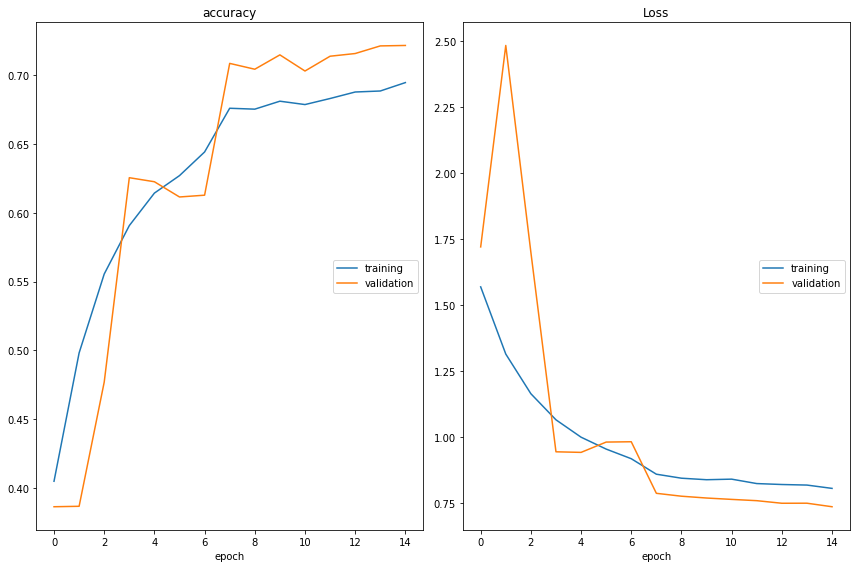

accuracy
	training         	 (min:    0.405, max:    0.695, cur:    0.695)
	validation       	 (min:    0.386, max:    0.722, cur:    0.722)
Loss
	training         	 (min:    0.805, max:    1.568, cur:    0.805)
	validation       	 (min:    0.735, max:    2.483, cur:    0.735)

Epoch 15: saving model to model_weights.h5
191/191 [==============================] - 12s 61ms/step - loss: 0.8047 - accuracy: 0.6946 - val_loss: 0.7351 - val_accuracy: 0.7216 - lr: 5.0000e-05


In [51]:
#Model 2 devamı
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
epochs = 15
steps_per_epoch = len(X_train) / batch_size
validation_steps = len(x_valid) / batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=valid_flow,
        validation_steps=validation_steps,
        callbacks=callbacks
)

In [ ]:
def Horus_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    return model

In [ ]:
model = Horus_Model()
#mdl.add(model)
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
checkpoint_path = path + "checkpoints/"
chfile_path = checkpoint_path + "checkpoint.{epoch:03d}-{loss:.2f}.h5"
checkpoint = ModelCheckpoint(chfile_path, monitor='loss', verbose=1, save_best_only=True, save_weight_only=False, mode='min')
callbacks_list = [checkpoint]

In [ ]:
num_epochs = 100  
#with tf.device('/gpu:1'):
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=valid_flow,
                    validation_steps=len(x_valid) / batch_size)
                    #,
                    #callbacks=callbacks_list)

In [ ]:
import os
model.load_weights(os.path.join("model_weights2.h5"))
#model.load_weights(os.path.join(checkpoint_path, "checkpoint.034-0.83.h5"))  #Specify the model of CHANGE THIS AFTER RESUME *****************************************************************************************************

In [ ]:
chfile_path = "model_weights.h5"
#checkpoint = ModelCheckpoint(chfile_path, monitor='loss', verbose=1, save_best_only=True, save_weight_only=False, mode='min')
startFrom = 127 #CHANGE THIS AFTER RESUME *****************************************************************************************************
#callbacks_list = [checkpoint]
checkpoint = ModelCheckpoint("model_weights2.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

In [ ]:
num_epochs = 300 
"""history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=valid_flow,
                    validation_steps=len(x_valid) / batch_size,
                    callbacks=callbacks_list, 
                    initial_epoch = startFrom
                    )"""
history = model.fit(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=valid_flow,
        validation_steps=validation_steps,
        callbacks=callbacks,
        initial_epoch = startFrom
)

In [52]:
#Save the Model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")
model.save(path + 'Models/modelHORUS_FER')

Saved model to disk
INFO:tensorflow:Assets written to: horus2.0\aligned\aligned\train_12271_aligned.jpgModels/modelHORUS_FER\assets
